# Stock Market Prediction And Forecasting Using Stacked LSTM

### 1) Data Collection

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

2024-08-08 17:16:09.923843: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 17:16:09.926210: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 17:16:09.933814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 17:16:09.945857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 17:16:09.949402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 17:16:09.959318: I tensorflow/core/platform/cpu_feature_gu

In [2]:
df = yf.download('AAPL')
print(df.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086999  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600


In [3]:
df.to_csv('AAPL.csv')

In [4]:
df=pd.read_csv('AAPL.csv')
df = df[6000:]

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
6000,2004-09-21,0.674107,0.694107,0.668929,0.678750,0.573851,386652000
6001,2004-09-22,0.680357,0.681071,0.657321,0.659286,0.557395,401688000
6002,2004-09-23,0.661429,0.669643,0.659464,0.665536,0.562679,397404000
6003,2004-09-24,0.668750,0.678571,0.663393,0.665893,0.562981,369488000
6004,2004-09-27,0.659821,0.678214,0.657679,0.670179,0.566605,397516000


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10999,2024-08-01,224.369995,224.479996,217.020004,218.360001,218.360001,62501000
11000,2024-08-02,219.149994,225.600006,217.710007,219.860001,219.860001,105568600
11001,2024-08-05,199.089996,213.500000,196.000000,209.270004,209.270004,119548600
11002,2024-08-06,205.300003,209.990005,201.070007,207.229996,207.229996,69660500
11003,2024-08-07,206.899994,213.639999,206.389999,209.820007,209.820007,63402300


In [7]:
df1=df.reset_index()['Close']

In [8]:
df1

0         0.678750
1         0.659286
2         0.665536
3         0.665893
4         0.670179
           ...    
4999    218.360001
5000    219.860001
5001    209.270004
5002    207.229996
5003    209.820007
Name: Close, Length: 5004, dtype: float64

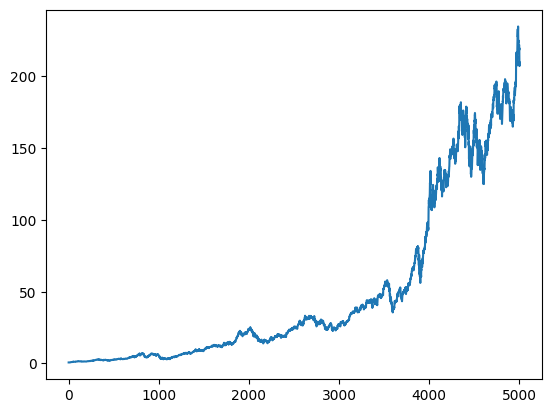

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

# 2) Data Scaling

In [10]:
df1

0         0.678750
1         0.659286
2         0.665536
3         0.665893
4         0.670179
           ...    
4999    218.360001
5000    219.860001
5001    209.270004
5002    207.229996
5003    209.820007
Name: Close, Length: 5004, dtype: float64

In [11]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0,1)) # Scaling data to [0,1]
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
# -1 --> Infer number of rows based on length of array

In [12]:
print(df1)

[[8.31222087e-05]
 [0.00000000e+00]
 [2.66909164e-05]
 ...
 [8.90886896e-01]
 [8.82174895e-01]
 [8.93235723e-01]]


# 3) Split Training and Testing Data

In [13]:
training_size=int(len(df1)*0.85)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size,test_size

(4253, 751)

In [15]:
import numpy
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2, ... , t+time_step-1 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(4152, 100)
(4152,)


(None, None)

In [18]:
print(X_test.shape), print(ytest.shape)

(650, 100)
(650,)


(None, None)

# 4) Create LSTM Model

In [19]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
# This step should always be done at the beginning of the LSTM Code
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()

# Layer 1
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # input shape should be same as [time_steps, features]

# Layer 2
model.add(LSTM(50,return_sequences=True))

# Layer 3
model.add(LSTM(50))

# Layer 4
model.add(Dense(1))

# Adam Optimizer with MSE as performance metric
model.compile(loss='mean_squared_error',optimizer='adam')

2024-08-08 17:16:12.477030: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-08-08 17:16:12.477053: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: streetcad
2024-08-08 17:16:12.477059: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: streetcad
2024-08-08 17:16:12.477153: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-08-08 17:16:12.477173: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-08-08 17:16:12.477178: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1
/home/fardeen/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.8584e-05 - val_loss: 0.0015
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.4402e-05 - val_loss: 0.0016
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.0159e-04 - val_loss: 0.0018
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.0108e-04 - val_loss: 0.0020
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.6998e-05 - val_loss: 9.7020e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.4900e-05 - val_loss: 0.0011
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 8.0303e-05 - val_loss: 8.0664e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 8.0093e-05 - val_loss: 8.2204e-04
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.8081e-05 - val_loss: 0.0016
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 6.2458e-05 - val_loss: 0.0029

# 5) Performance Analysis

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [25]:
train_predict

array([[0.00504643],
       [0.00509027],
       [0.00522855],
       ...,
       [0.6223095 ],
       [0.6180805 ],
       [0.618377  ]], dtype=float32)

In [26]:
# Transform the data back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [27]:
train_predict

array([[  1.8409624],
       [  1.8512282],
       [  1.8836074],
       ...,
       [146.37973  ],
       [145.38947  ],
       [145.4589   ]], dtype=float32)

In [28]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

42.36439395807233

In [29]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

168.23158751931086

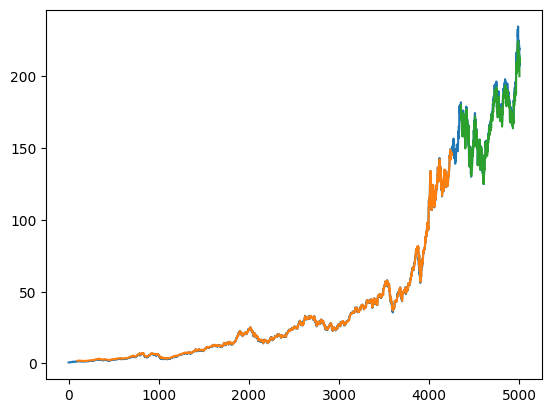

In [30]:
# Plotting results
# Shift train predictions for plotting
look_back = time_step
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Fill the train predictions into the shifted positions of the trainPredictPlot array


# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Fill the test predictions into the shifted positions of the testPredictPlot array


# Plot the baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 6) Predict stock price for the next 30 days

In [31]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
# Converting datatype to list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
temp_input

[0.734370427878882,
 0.7390680821114071,
 0.7491466324217622,
 0.7602073958302841,
 0.7290322140527139,
 0.7329184493574626,
 0.726811564018923,
 0.7219431156160074,
 0.7373171323371257,
 0.7295019794759664,
 0.72330966447036,
 0.7182276744816491,
 0.7216868266148072,
 0.7181423099783254,
 0.7213879205256881,
 0.7165621543744345,
 0.7217722562818739,
 0.7137008795832576,
 0.7447052020266942,
 0.7511538060335008,
 0.734669399131744,
 0.7205338193462498,
 0.7146404104297626,
 0.7105406335392185,
 0.7018286972469592,
 0.7054159612988458,
 0.7099427561972375,
 0.7189964111577637,
 0.7227117871283789,
 0.720192165841726,
 0.7381285512649021,
 0.724590848821389,
 0.720192165841726,
 0.7361213776531634,
 0.7803218141993323,
 0.773189968347221,
 0.7761366076417218,
 0.7775886513268842,
 0.7854038041880432,
 0.7789125179295748,
 0.792706444210545,
 0.7976175748651225,
 0.8073972190863585,
 0.807909666761273,
 0.8080377786800015,
 0.8130343390016457,
 0.8186288418290137,
 0.8124364616596647,
 0.

In [34]:
# Prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=time_step
i=0
while(i<30):
    # If input data contains more number of elements than time step
    if(len(temp_input) > time_step):
        # Shifting and reshaping input
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        # Make Prediction
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        x_input = x_input.reshape((1, n_steps,1)) # Reshape data

        yhat = model.predict(x_input, verbose=0) # Make Prediction
        print("{} day output {}".format(i,yhat))

        # Add prediction to previous input and final output
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

0 day output [[0.87500966]]
1 day input [0.73906808 0.74914663 0.7602074  0.72903221 0.73291845 0.72681156
 0.72194312 0.73731713 0.72950198 0.72330966 0.71822767 0.72168683
 0.71814231 0.72138792 0.71656215 0.72177226 0.71370088 0.7447052
 0.75115381 0.7346694  0.72053382 0.71464041 0.71054063 0.7018287
 0.70541596 0.70994276 0.71899641 0.72271179 0.72019217 0.73812855
 0.72459085 0.72019217 0.73612138 0.78032181 0.77318997 0.77613661
 0.77758865 0.7854038  0.77891252 0.79270644 0.79761757 0.80739722
 0.80790967 0.80803778 0.81303434 0.81862884 0.81243646 0.79526881
 0.80850754 0.80855029 0.80983141 0.81410198 0.81820176 0.82580337
 0.82716998 0.83366121 0.82772511 0.83801721 0.82191713 0.88183324
 0.90711508 0.91211164 0.90463814 0.9224891  0.91232512 0.89263778
 0.88328529 0.88606113 0.8900328  0.90788375 0.91151376 0.89665213
 0.92283075 0.93786318 0.9433295  0.96378551 0.970106   0.97377863
 0.9921421  0.96903836 0.9817219  0.9982063  1.         0.9746328
 0.95456106 0.95511626 0.

In [35]:
day_new  = np.arange(1,101)
day_pred = np.arange(101,131)

In [36]:
len(df1)

5004

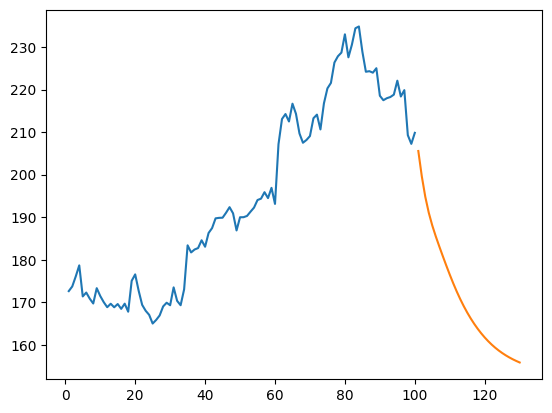

In [37]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

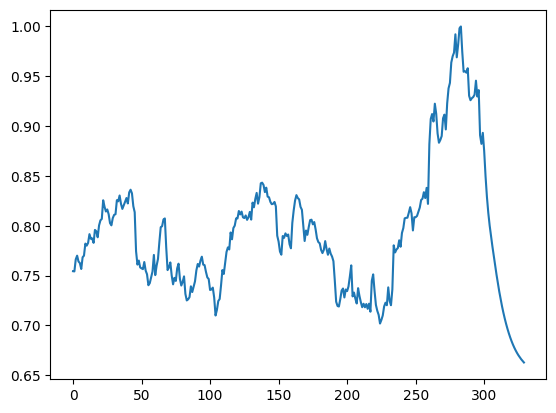

In [38]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[len(df1)-300:])

In [39]:
df3=scaler.inverse_transform(df3).tolist()

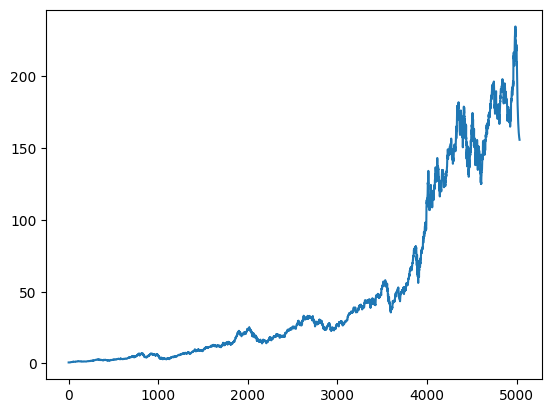

In [40]:
plt.plot(df3)